# Identifying stations outside their region in OSCAR
In OSCAR/Surface the region of a station is an attribute that is independent of the station location. Therefore it is in theory possible to put a station outside the indicated area. This notebook identifies stations outside their area. It uses online data retrieved from APIs so as to be useful in the future 

In [29]:
# first we import the libraries we will be working with 
import requests 
import json
import urllib.parse
import geopandas as gpd
import pandas as pd
from io import StringIO
from shapely.geometry import Point

OSCAR/Surface has a hidden API that is used to download stations from the advanced station search form. Using the network inspector of my browser I could identify the API endpoint URL and the names and values of the parameters. I used the **stationTypeIdList** to select land stations (as air or ocean stations inherently tend to be outside their home regions) and the **latitudeFrom**, **longitudeFrom**, **latitudeTo** and **longitudeTo** to draw a bounding box around my area of interest.

In [30]:
url = "https://oscar.wmo.int/surface//rest/api/search/download/stationSRs"

parameters = {"operation":"AND","nrt": 'false',"quickSearch":False,"wmoRaOrCountryId":"","latitudeFrom":-45.393421779302194,
        "longitudeFrom":77.78644921871577,"latitudeTo":55.53268317149922,"longitudeTo":176.9270742186897,
        "tableParams":{"page":1,"count":10,"filter":{},"sorting":{"region":"asc","territory":"asc"},"group":{},"groupBy":None},
        "stationTypeIdList":[1,2,11,12,9],"stationProgramName":None,"variableName":None,"filetype":"csv"}

# rather unintuitive way to encode parameters... 
# a JSON array could in reality just be passed in as JSON rather than encoding it in this way
payload =   'data=' + urllib.parse.quote(json.dumps(parameters ))

r = requests.post(url,data=payload) # download the result.. it is a CSV file

we load the CSV file into a pandas dataframe for analysis. Use StringIO to leverage the read_csv function of pandas

In [31]:
data = StringIO( r.text )
df = pd.read_csv(data, sep=";")
df=df.rename(columns={'WMO Region':'WMO Region attribute'})

convert the dataframe into a geopandas object for spatial analysis

In [32]:
geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
df = df.drop(['Longitude', 'Latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf_stations = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

Now we need a spatial representation of the WMO regions. Fortunately there is a GeoJSON encoded representation of the WMO regions on the CPDB website

In [33]:
%matplotlib inline

url_regions = 'https://www.wmo.int/cpdb/js/json/WMO_regions.json'
gdf_regions = gpd.read_file (url_regions)
gdf_regions=gdf_regions.rename(columns={'Roman_Region':'Roman Region coords'})

Let's print stations and WMO regions

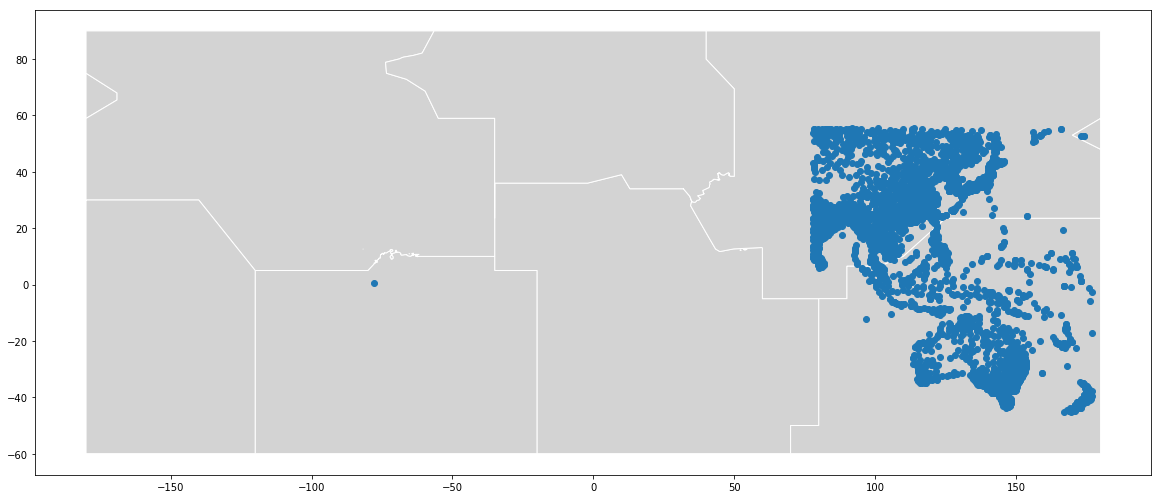

In [34]:
ax=gdf_regions.plot( edgecolor='white', color='lightgrey' , figsize=(20,12))
gdf_stations.plot(ax=ax)

We can see WMO regions and stations.. but which ones are outside their region? For this we need to use more geospatial analysis. Let's join the stations and regions using a geospatial join on 'within', to join regions and stations that are contained *within* the region.

In [35]:
stations_by_region = gpd.sjoin(  gdf_stations, gdf_regions , how='inner' , op='within' )

In [36]:
print("the regions occurring in the result are:")
print(stations_by_region["WMO Region attribute"].unique())

the regions occurring in the result are:
['Asia' 'North America, Central America and the Caribbean' 'South America'
 'South-West Pacific']


In [37]:
# convert text based region to roman numerals to be able to better compare below
stations_by_region["WMO Region Roman attribute"] =  stations_by_region["WMO Region attribute"].apply( lambda r: 
                                       "II" if r == 'Asia' 
                                       else 'IV'  if r == 'North America, Central America and the Caribbean' 
                                       else 'III' if r == 'South America'
                                       else 'V'   if r == 'South-West Pacific'
                                       else None )

In [38]:
temp = stations_by_region[ ["Station", "Country" ,"WMO Region Roman attribute","Roman Region coords" , "geometry"] ]
# select stations where the joined region does not correspond to actual region
estranged_stations = temp[ temp["WMO Region Roman attribute"] != temp["Roman Region coords"] ] 

now list and plot the stations outside their region on top of the map and in a different color

,Station,Country,WMO Region Roman attribute,Roman Region coords,geometry
1964,RADAR Pga,Belize,IV,II,POINT (88.3 17.5333333333)
1969,RADAR Vladivostok,Russian Federation,III,II,POINT (132.05 42.35)
3236,ITBAYAT,Philippines,V,II,POINT (121.8513888889 20.8013888889)
328,NANSHA DAO,China,II,V,POINT (114.3666666667 10.3833333333)
483,YONGSHUJIAO,China,II,V,POINT (112.8833333333 9.5333333333)
1942,HUYEN TRAN,Viet Nam,II,V,POINT (110.6166666667 8.016666666699999)
1957,SONG TU TAY (SOUTH WEST CAY),Viet Nam,II,V,POINT (114.3333333333 11.4166666667)
1961,TRUONG SA,Viet Nam,II,V,POINT (111.9166666667 8.65)


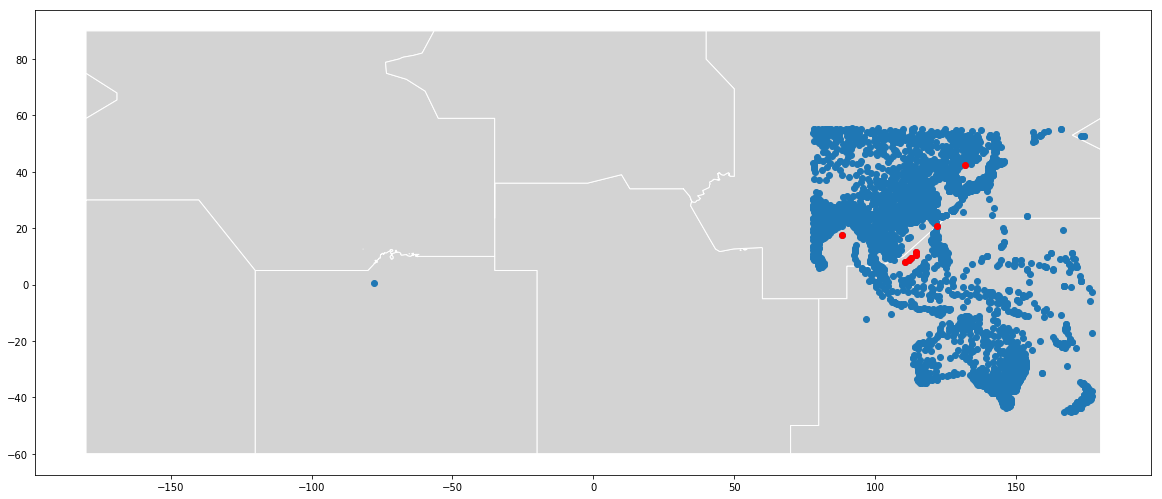

In [39]:
ax = gdf_regions.plot( edgecolor='white', color='lightgrey' , figsize=(20,12))
gdf_stations.plot(ax=ax)
estranged_stations.plot(ax=ax, color='red')
estranged_stations